In [3]:
#To access youtube comments using youtube API we should Authenticate
import os

SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

#Get the youtube API key and download client_secrets.json file

CLIENT_SECRETS_FILE  = os.path.join('/content/drive/My Drive/Colab Notebooks/client_secrets.json')

In [4]:
import google.oauth2.credentials

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow


def get_authenticated_service():
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
    credentials = flow.run_console()
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)


os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
service = get_authenticated_service()


#code to cache the login details
import os
import pickle
import google.oauth2.credentials

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

...
...

def get_authenticated_service():
    credentials = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    #  Check if the credentials are invalid or do not exist
    if not credentials or not credentials.valid:
        # Check if the credentials have expired
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_console()

        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(credentials, token)

    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=782597543999-lchm7ola2u3ubdj9rkqgpu2uvun3vlvq.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=cm1TPsP2hrmrrWoMEwFl4UOvKoTl1l&prompt=consent&access_type=offline
Enter the authorization code: 4/1wFaBGbdwcZzdQ5quuYW0qCqpNFWN66jJIafYsp2EsfjqS349prcSZc


In [7]:
def get_comment_threads(youtube, video_id, comments=[], token=""):
    results = youtube.commentThreads().list(
        part="snippet",
        pageToken=token,
        videoId=video_id,
        textFormat="plainText"
    ).execute()

    for item in results["items"]:
        comment = item["snippet"]["topLevelComment"]
        text = comment["snippet"]["textDisplay"]
        comments.append(text)

    if "nextPageToken" in results:
        return get_comment_threads(youtube, video_id, comments, results["nextPageToken"])
    else:
        return comments

In [8]:
#Python code for getting videoid from url

from urllib.parse import urlparse, parse_qs

def extract_video_id(url):
    # Examples:
    # - http://youtu.be/SA2iWivDJiE
    # - http://www.youtube.com/watch?v=_oPAwA_Udwc&feature=feedu
    # - http://www.youtube.com/embed/SA2iWivDJiE
    # - http://www.youtube.com/v/SA2iWivDJiE?version=3&amp;hl=en_US
    query = urlparse(url)
    if query.hostname == 'youtu.be': return query.path[1:]
    if query.hostname in ('www.youtube.com', 'youtube.com'):
        if query.path == '/watch': return parse_qs(query.query)['v'][0]
        if query.path[:7] == '/embed/': return query.path.split('/')[2]
        if query.path[:3] == '/v/': return query.path.split('/')[2]
    # fail?
    return None

url = input('Enter url of the video : ') # we can directly give videoid
videoid = extract_video_id(url)

Enter url of the video : https://www.youtube.com/watch?v=4KcMdH8qiuk


In [ ]:
comments = get_comment_threads(service,videoid) #to get comments of the video


In [19]:
#Using Neural Networks to Train our model

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
#this is a model from tensorflow hub to convert text in to a vector

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
                           input_shape=[], dtype=tf.string,trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
#Dataset of 50000 movie reviews to train our model
dataset  = os.path.join('/content/drive/My Drive/Colab Notebooks/IMDB Dataset.csv')
df = pd.read_csv(dataset)

In [14]:
#Encoding positive as 1 and negative as 0
sentiment = [0 if df['sentiment'][i]=='negative' else 1 for i in range(df.shape[0])]
df = df.drop('sentiment',axis=1)
df['sentiment'] = sentiment

reviews = np.asarray(df.review)
sentiments = np.asarray(df.sentiment)
comments = np.array(comments)

In [15]:
model.fit(reviews,sentiments,batch_size=500,epochs=20)
result = model.predict(comments)

Epoch 1/20
100/100 [==============================] - 4s 44ms/step - loss: 0.9546 - accuracy: 0.5273
Epoch 2/20
100/100 [==============================] - 4s 44ms/step - loss: 0.5386 - accuracy: 0.7364
Epoch 3/20
100/100 [==============================] - 4s 44ms/step - loss: 0.4355 - accuracy: 0.8064
Epoch 4/20
100/100 [==============================] - 4s 44ms/step - loss: 0.3657 - accuracy: 0.8447
Epoch 5/20
100/100 [==============================] - 4s 43ms/step - loss: 0.3205 - accuracy: 0.8659
Epoch 6/20
100/100 [==============================] - 4s 44ms/step - loss: 0.2904 - accuracy: 0.8811
Epoch 7/20
100/100 [==============================] - 4s 44ms/step - loss: 0.2674 - accuracy: 0.8918
Epoch 8/20
100/100 [==============================] - 5s 45ms/step - loss: 0.2496 - accuracy: 0.8993
Epoch 9/20
100/100 [==============================] - 5s 45ms/step - loss: 0.2360 - accuracy: 0.9064
Epoch 10/20
100/100 [==============================] - 4s 44ms/step - loss: 0.2247 - accura

In [16]:
positive_comments = []
negative_comments = []
neutral_comments =  []

for i in result:
  if i> 0.3 and i<0.7:
    neutral_comments.append(i)
  elif i<0.3:
    negative_comments.append(i)
  elif i>0.7:
    positive_comments.append(i)
  

In [17]:
print('After Analysing',comments.shape[0],'comments :')
print('The result is')
print()
print('Total positive comments',len(positive_comments))
print('Total Negative comments',len(negative_comments))
print('Total Neutral comments',len(neutral_comments))


After Analysing 6809 comments :
The result is

Total positive comments 2973
Total Negative comments 1480
Total Neutral comments 2356


([<matplotlib.patches.Wedge at 0x7f3d1059fe80>,
 [Text(0.2175541130478004, 1.0782718617751208, 'positive'),
  Text(-1.055727809929897, -0.3089316936486503, 'negative'),
  Text(0.5116274814880101, -0.9737747789844612, 'Neutral')],
 [Text(0.11866587984425475, 0.5881482882409749, '43.66'),
  Text(-0.5758515326890347, -0.1685081965356274, '21.74'),
  Text(0.2790695353570964, -0.5311498794460696, '34.60')])

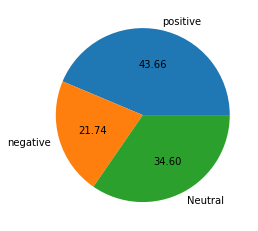

In [27]:
data = [len(positive_comments),len(negative_comments),len(neutral_comments)]
labels=['positive','negative','Neutral']
plt.pie(data,labels=labels,autopct='%.2f')
